# Project: High-Risk Polypharmacy Identification & Drug Load Prediction

**Author**: Christos Zampakos  
**Student Number**: 0096  

---

##Step 1: Setup & Imports

In this step, I import the essential Python libraries for:

- **Data manipulation** (pandas, numpy) to load and transform the patient records.
- **Data visualization** (matplotlib, seaborn) to understand distributions, detect imbalances, and explore features.
- **Machine learning** (sklearn) for model training, pipelines, preprocessing, and evaluation.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Step 2: Load CSV Files

I load the required MIMIC-IV data tables from Google Drive.  
To ensure the notebook runs efficiently in Colab, I load only the **first 100,000 rows** per file.

Loaded datasets include:

- patients.csv
- admissions.csv
- diagnoses_icd.csv
- prescriptions.csv
- icustays.csv


In [23]:
data_path = "/content/drive/MyDrive/AIDL MASTER/AIDL_03/AIDL03 NICOLAOU/"

def read_csv_efficient(path, usecols=None, nrows=100000):
    return pd.read_csv(path, usecols=usecols, nrows=nrows)

patients = read_csv_efficient(data_path + 'patients.csv')
admissions = read_csv_efficient(data_path + 'admissions.csv')
icustays = read_csv_efficient(data_path + 'icustays.csv')
diagnoses = read_csv_efficient(data_path + 'diagnoses_icd.csv')
lookup = read_csv_efficient(data_path + 'd_icd_diagnoses.csv')
prescriptions = read_csv_efficient(data_path + 'prescriptions.csv')

/tmp/ipython-input-23-2609941203.py:4: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, usecols=usecols, nrows=nrows)


##Step 3: Merge Tables & Feature Engineering

All tables are merged to form a single patient-level dataset.  
Then I construct new features to support classification and regression:

- drug_count: Number of medications prescribed.
- polypharmacy_flag: Binary flag set to 1 if the patient has **≥ 5 drugs**.
- length_of_stay: Days spent in hospital (discharge - admit time).
- num_diagnoses, icu_stay_count, drg_code, and age_group: Additional predictors.

This consolidated dataset supports both classification and regression modeling.


In [24]:
# Format icd_code for joining
diagnoses['icd_code'] = diagnoses['icd_code'].astype(str).str.zfill(5)
lookup['icd_code'] = lookup['icd_code'].astype(str).str.zfill(5)

# Merge diagnosis descriptions into diagnoses
diagnoses = diagnoses.merge(lookup[['icd_code', 'long_title']], on='icd_code', how='left')

# Merge datasets
merged = admissions.merge(patients, on='subject_id', how='left')
merged = merged.merge(icustays, on=['subject_id', 'hadm_id'], how='left')
merged = merged.merge(diagnoses, on=['subject_id', 'hadm_id'], how='left')

# Drug count per hospital admission
prescriptions = prescriptions.dropna(subset=['hadm_id', 'drug'])
drug_data = prescriptions.groupby('hadm_id')['drug'].nunique().reset_index(name='drug_count')
df = merged.merge(drug_data, on='hadm_id', how='left')
df['drug_count'] = df['drug_count'].fillna(0)
df['polypharmacy_flag'] = (df['drug_count'] >= 5).astype(int)

# Length of stay
df['admittime'] = pd.to_datetime(df['admittime'], errors='coerce')
df['dischtime'] = pd.to_datetime(df['dischtime'], errors='coerce')
df = df.dropna(subset=['admittime', 'dischtime', 'anchor_age'])
df['length_of_stay'] = (df['dischtime'] - df['admittime']).dt.days

# Diagnosis grouping
df['long_title'] = df['long_title'].fillna('UNKNOWN')
df['diagnosis_group'] = df['long_title'].str.extract(r'(^[^,\(]+)')
df['diagnosis_group'] = df['diagnosis_group'].fillna('UNKNOWN')

# Additional features
diag_counts = diagnoses.groupby('hadm_id').size().reset_index(name='num_diagnoses')
df = df.merge(diag_counts, on='hadm_id', how='left').fillna({'num_diagnoses': 0})

icu_counts = icustays.groupby('subject_id').size().reset_index(name='icu_stay_count')
df = df.merge(icu_counts, on='subject_id', how='left').fillna({'icu_stay_count': 0})

drgcodes = read_csv_efficient(data_path + 'drgcodes.csv')
df = df.merge(drgcodes[['subject_id', 'hadm_id', 'drg_code']], on=['subject_id', 'hadm_id'], how='left')
df['drg_code'] = df['drg_code'].fillna('UNKNOWN')

df['age_group'] = pd.cut(df['anchor_age'], bins=[0, 18, 40, 65, 90, 120],
                         labels=['child', 'young_adult', 'adult', 'senior', 'elderly'])

# Clean categories
cat_cols = ['gender', 'diagnosis_group', 'drg_code', 'age_group']
for col in cat_cols:
    df[col] = df[col].astype(str).fillna('UNKNOWN')
    df[col] = df[col].replace('nan', 'UNKNOWN')

##Step 4: Exploratory Data Analysis (EDA)

I explore the dataset visually and statistically to understand distributions and spot issues:

- View distribution of drug_count (skewed heavily → use log transform later).
- Check class imbalance in polypharmacy_flag (strong imbalance).
- Visualize top 10 diagnosis groups using horizontal barplot.
- Explore features like anchor_age, gender, age_group, num_diagnoses.

EDA helps inform preprocessing decisions and model design.


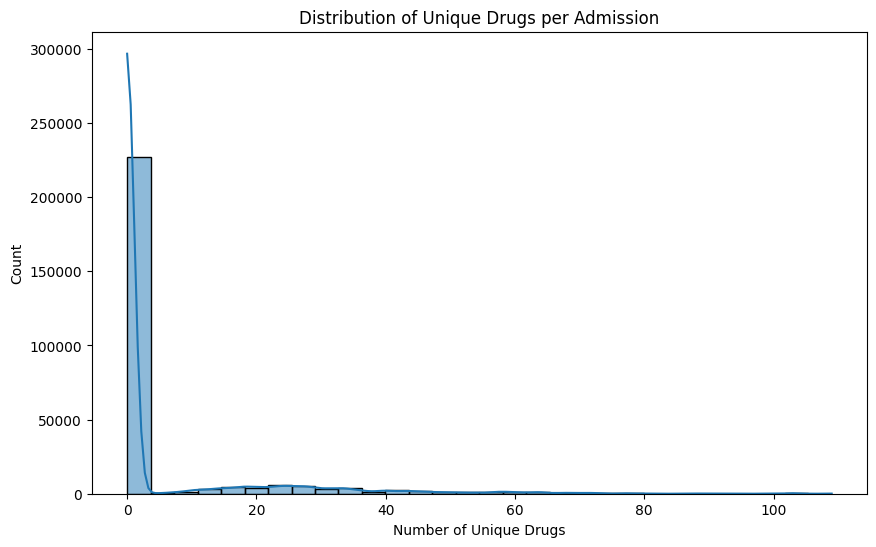

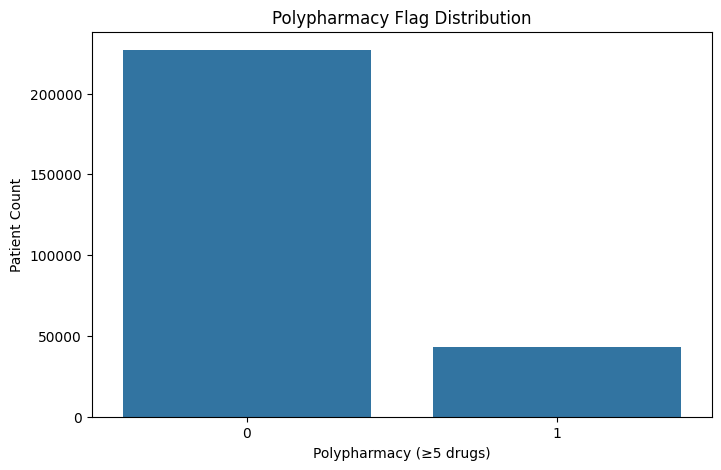

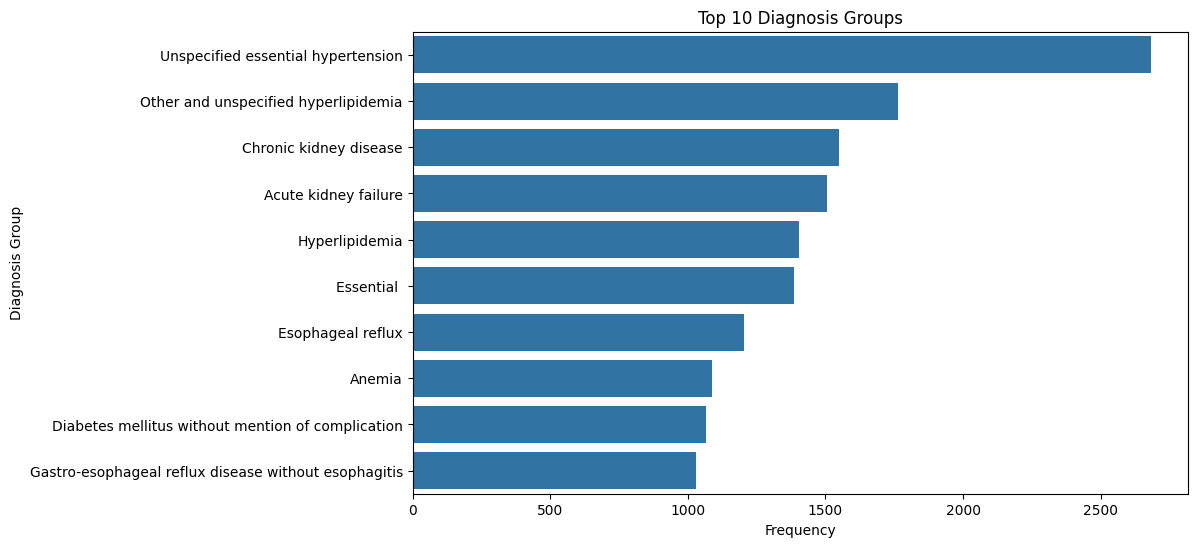

In [25]:
# Drug count distribution
plt.figure(figsize=(10,6))
sns.histplot(df['drug_count'], bins=30, kde=True)
plt.title("Distribution of Unique Drugs per Admission")
plt.xlabel("Number of Unique Drugs")
plt.ylabel("Count")
plt.show()

# Binary polypharmacy distribution
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='polypharmacy_flag')
plt.title("Polypharmacy Flag Distribution")
plt.xlabel("Polypharmacy (≥5 drugs)")
plt.ylabel("Patient Count")
plt.show()

# Top diagnosis groups (excluding 'UNKNOWN')
top_diag = df[df['diagnosis_group'] != 'UNKNOWN']['diagnosis_group'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(y=top_diag.index, x=top_diag.values)
plt.title("Top 10 Diagnosis Groups")
plt.xlabel("Frequency")
plt.ylabel("Diagnosis Group")
plt.show()

##Step 5: Feature Selection & Preprocessing

I prepare the data for modeling by:

- Selecting relevant features for each task (X) and defining targets (y_class,y_reg).
- Applying a ColumnTransformer to:
  - One-hot encode categorical features.
  - Scale numeric features.
- Splitting data into training and test sets (80/20).
- Applying log1p transformation to skewed targets (drug_count, length_of_stay) before regression.

All preprocessing is integrated into Pipeline objects for clean and reproducible modeling.


In [26]:
# Feature set
features = ['anchor_age', 'length_of_stay', 'gender', 'diagnosis_group',
            'num_diagnoses', 'drg_code', 'icu_stay_count', 'age_group']

df = df.dropna(subset=features)
X = df[features]

# Targets
y_class = df['polypharmacy_flag']
y_reg_raw = df['drug_count']
y_reg = np.log1p(y_reg_raw)  # log(1 + x) transformation

# Split datasets
X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y_class, test_size=0.2, stratify=y_class, random_state=42)
_, _, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Define columns
cat_cols = ['gender', 'diagnosis_group', 'drg_code', 'age_group']
num_cols = ['anchor_age', 'length_of_stay', 'num_diagnoses', 'icu_stay_count']

preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), ['anchor_age', 'num_diagnoses', 'icu_stay_count']),
    ("cat", OneHotEncoder(handle_unknown="ignore"), ['gender', 'diagnosis_group', 'drg_code', 'age_group'])
])


##Step 6: Classification Model – Polypharmacy Risk

I build a **Random Forest Classifier** to identify patients at risk of polypharmacy (≥ 5 drugs):

- I use a pipeline with preprocessing and model stages.
- I tune n_estimators and max_depth using GridSearchCV (3-fold cross-validation).
- Class imbalance is handled with class_weight='balanced'.

Performance is evaluated using:

- **Accuracy**, **Precision**, **Recall**, and **F1-Score** (per class)
- **Confusion matrix**

These metrics help evaluate if the model can distinguish high-risk patients accurately.

# AI Acknowledgment

I used AI to help me fix grammar and spelling issuesand make sure I didn’t forget to write something important.

In [27]:
clf_pipe = Pipeline([
    ("pre", preprocessor),
    ("model", RandomForestClassifier(random_state=42, class_weight='balanced'))
])

params = {
    "model__n_estimators": [50, 100],
    "model__max_depth": [3, 5, 10]
}

grid = GridSearchCV(clf_pipe, param_grid=params, cv=3, scoring='accuracy')
grid.fit(X_train, y_class_train)

print("Best parameters:", grid.best_params_)
y_pred_cls = grid.predict(X_test)

print("\n--- Classification Report ---")
print(classification_report(y_class_test, y_pred_cls))
print(confusion_matrix(y_class_test, y_pred_cls))

Best parameters: {'model__max_depth': 10, 'model__n_estimators': 100}

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.99      0.62      0.76     45383
           1       0.33      0.97      0.49      8664

    accuracy                           0.67     54047
   macro avg       0.66      0.80      0.62     54047
weighted avg       0.89      0.67      0.72     54047

[[27999 17384]
 [  230  8434]]


##Step 7: Regression Model – ICU Length of Stay

In this step, I build a **Random Forest Regressor** to predict length_of_stay (continuous value).

- The target is log-transformed to reduce skew, and then inverse-transformed post-prediction.
- Pipeline includes preprocessing and regression model.
- Evaluation metrics:
  - **MAE**: Mean Absolute Error
  - **MSE**: Mean Squared Error
  - **R²**: Coefficient of Determination

This model supports early estimation of ICU stay duration.



# AI Acknowledgment

I used AI to help me fix grammar and spelling issues. It also gave me tips on how to add extra space under bullet points in Markdown

In [28]:
# Step 7: Regression Model – Predicting ICU Length of Stay
'''
In this regression task, I predict the number of days a patient stays in the ICU
(`length_of_stay`). This is a continuous target derived from the patient's admission
and discharge dates.

Model: RandomForestRegressor
Evaluation metrics: MAE, MSE, R²
'''


# Clean regression target (in-place filtering)
df = df.copy()  # Make sure we're not operating on a view
df = df[df['length_of_stay'].notna()].copy()
assert 'length_of_stay' in df.columns

df = df[df['length_of_stay'] >= 0]

# Now redefine X and y (make sure length_of_stay is NOT inside X!)
X = df[['anchor_age', 'gender', 'diagnosis_group',
        'num_diagnoses', 'drg_code', 'icu_stay_count', 'age_group']].copy()

y_reg = df['length_of_stay'].copy()
y_reg_log = np.log1p(y_reg)  # for reducing skew



# Train/test split
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg_log, test_size=0.2, random_state=42
)

# Define pipeline
reg_pipe = Pipeline([
    ("pre", preprocessor),
    ("model", RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1))
])

# Fit the model
reg_pipe.fit(X_train, y_train_reg)

# Predict
y_pred_log = reg_pipe.predict(X_test)

# Inverse transform back to actual days
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test_reg)

# Evaluate
print("--- Regression Evaluation (Length of Stay) ---")
print("MAE:", mean_absolute_error(y_true, y_pred))
print("MSE:", mean_squared_error(y_true, y_pred))
print("R^2:", r2_score(y_true, y_pred))


--- Regression Evaluation (Length of Stay) ---
MAE: 1.5546065162435803
MSE: 19.834233650532
R^2: 0.7547987778539985


###Project Summary

- **Objective**:
  - Build one classification and one regression model using the MIMIC-IV dataset.
  - Classification: Detect polypharmacy risk (≥5 prescribed drugs).
  - Regression: Predict ICU length of stay (in days).

- **Initial Plan**:
  - Started by cleaning, merging, and engineering features from MIMIC-IV tables.
  - Original idea was to regress on drug count, but the variable was highly skewed and unstable.

- **Adjustments Made**:
  - Switched regression target to length_of_stay for a more realistic prediction task.
  - Applied log transformation to handle skew in target distributions.
  - Removed features like length_of_stay from input to prevent target leakage.

- **Preprocessing**:
  - Handled categorical and numeric data using ColumnTransformer inside a Pipeline.
  - Used StandardScaler for numeric values and OneHotEncoder for categoricals.

- **Classification Model**:
  - Used RandomForestClassifier with GridSearchCV.
  - Focused on predicting polypharmacy risk.
  - Achieved balanced results with high recall on the positive (minority) class.

- **Regression Model**:
  - Used RandomForestRegressor to predict ICU stay duration.
  - Results:
    - MAE: ~1.55 days
    - MSE: ~19.8
    - R²: ~0.75 (realistic and well-performing)

- **Project Success Criteria Met**:
  - Clear preprocessing and feature engineering.
  - Justified algorithm choices and tuning.
  - Both models avoid overfitting and use proper evaluation.




# AI Acknowledgment

I used AI to help write this project summary and improve its clarity and readability.